In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


In [267]:
df_modelo = pd.read_csv(r'C:\Users\Thyana De Lara\Documents\TCC\modelo_vendas_forecasting\versão_3\2.1.dados_limpos.csv')

## Criação de novas variáveis para análise

In [ ]:
#Criar lags de 3 mês
df_modelo['dias_ativos_venda_lag3'] = df_modelo.groupby(['store_nbr', 'family_top6'])['dias_ativos_venda'].transform(lambda x: x.shift(1).rolling(3).mean())

#Preencher os nulos com zero
df_modelo['dias_ativos_venda_lag3'] = df_modelo['dias_ativos_venda_lag3'].fillna(0)

df_modelo['quarter'] = df_modelo['mes'].apply(lambda x: (x - 1) // 3 + 1)
df_modelo['has_promo'] = (df_modelo['onpromotion'] > 0).astype(int) 

df_modelo['is_fim_ano'] = df_modelo['mes'].isin([11,12]).astype(int)
df_modelo['sazonal_forte'] = df_modelo['mes'].isin([2,5,3]).astype(int)  # conforme análise visual do erro por mês

## Normalização e Escalonamento

In [271]:
# Colunas numéricas e categóricas da sua base
colunas_numericas = ['onpromotion', 'qtd_feriados', 'dias_ativos_venda','dias_ativos_venda_lag3']
colunas_categoricas = ['store_nbr', 'family_top6', 'date', 'quarter'] 

# Juntar as colunas que serão usadas
colunas_usadas = colunas_numericas + colunas_categoricas

# Selecionar os dados
X = df_modelo[colunas_usadas]

# One-Hot Encoding para variáveis categóricas
X_encoded = pd.get_dummies(X, columns=colunas_categoricas, drop_first=True)

# Normalizar colunas numéricas com MinMaxScaler
scaler = MinMaxScaler()
X_encoded[colunas_numericas] = scaler.fit_transform(X_encoded[colunas_numericas])


In [273]:
df_modelo['log_sales'] = np.log1p(df_modelo['sales'])

## Análise de correlação entre variáveis numéricas

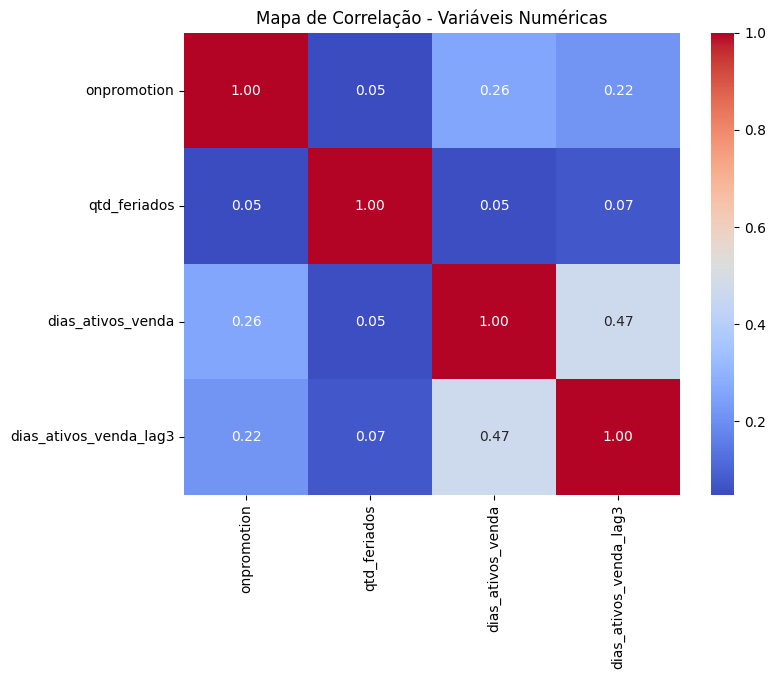

In [280]:
correlacao = df_modelo[colunas_numericas].corr()

# Plota o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação - Variáveis Numéricas')
plt.show()

## Divisão em treino e teste

In [ ]:
# Período de treino
X_treino = X_encoded[(df_modelo['ano'] >= 2013) & (df_modelo['ano'] <= 2015)]
Y_treino = df_modelo.loc[X_treino.index, 'log_sales'] 

# Período de teste
X_teste = X_encoded[(df_modelo['ano'] >= 2016) ]
Y_teste = df_modelo.loc[X_teste.index, 'log_sales']
print(f"Treino: {X_treino.shape}, Teste: {X_teste.shape}")

Treino: (61198, 120), Teste: (31441, 120)


## Avaliação dos modelos RandomForest e XGBoost

In [278]:
# Função para avaliação
def avaliar_modelo(nome, modelo):
    modelo.fit(X_treino, Y_treino)
    y_pred = modelo.predict(X_teste)
    # Reverter o log para obter as vendas reais
    y_pred_real = np.expm1(y_pred)
    y_pred_real = np.clip(y_pred_real, 0, None)  # impede valores negativos

    # Reverter o target real para mesma escala
    y_real = np.expm1(Y_teste)
    return {
        'Modelo': nome,
        'MAE': mean_absolute_error(y_real, y_pred_real),
        'RMSE': mean_squared_error(y_real, y_pred_real, squared=False),
        'R2': r2_score(Y_teste, y_pred)
    }

# Testar dois modelos
resultados = []
resultados.append(avaliar_modelo("RandomForest", RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)))
resultados.append(avaliar_modelo("XGBoost", XGBRegressor(n_estimators=200,max_depth=15 ,learning_rate=0.05, subsample=0.8, colsample_bytree=1, random_state=42, n_jobs=-1)))

In [279]:
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

         Modelo          MAE         RMSE        R2
0  RandomForest  2292.949935  4632.074253  0.894830
1       XGBoost  2132.752709  4100.291120  0.897266


## GridSearchCV 
Para encontrar a melhor combinação de hiperparâmetros de um modelo por meio de validação cruzada

In [281]:
# Parâmetros a testar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Modelo base
xgb = XGBRegressor(random_state=42, n_jobs=-1)

# Grid Search com validação cruzada
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                    scoring='neg_root_mean_squared_error',
                    cv=3, verbose=1)

grid.fit(X_treino, Y_treino)

# Melhor combinação
print("Melhores parâmetros encontrados:", grid.best_params_)
print("Melhor RMSE (negativo):", grid.best_score_)

# Previsão no conjunto de teste
y_pred = grid.best_estimator_.predict(X_teste)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Melhores parâmetros encontrados: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Melhor RMSE (negativo): -0.9508283768580608


## Modelagem e Avaliação das métricas de erro

📈 Métricas na Escala Real:
MAE:  2,366.62
RMSE: 4,417.55
R²:   0.8010


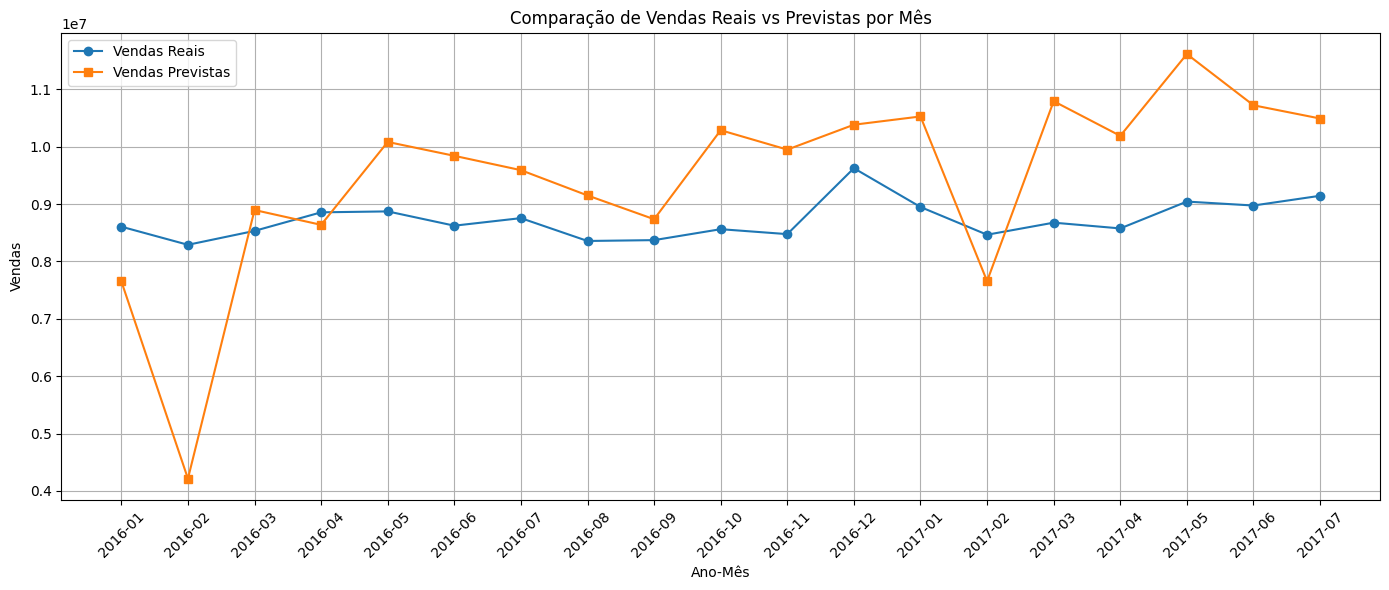

In [ ]:
# Obter as previsões do melhor modelo
xgb_model = XGBRegressor(n_estimators=300,max_depth=5 ,learning_rate=0.05, subsample=0.8, colsample_bytree=1, random_state=42, n_jobs=-1)
xgb_model.fit(X_treino, Y_treino)
y_pred_log = xgb_model.predict(X_teste)
y_real = np.expm1(Y_teste) #retira log
y_pred = np.expm1(y_pred_log)

# Criar DataFrame com resultados no log
df_resultado_log = df_modelo.loc[Y_teste.index, ['ano', 'mes']].copy()
df_resultado_log['log_real'] = Y_teste
df_resultado_log['log_previsto'] = y_pred_log

# Converter os logs para escala original (antes de agrupar!)
df_resultado_log['sales_real'] = np.expm1(df_resultado_log['log_real'])
df_resultado_log['sales_prevista'] = np.expm1(df_resultado_log['log_previsto'])

# Agregar por mês (usando média dos logs para não distorcer)
df_mensal = df_resultado_log.groupby(['ano', 'mes'])[['sales_real', 'sales_prevista']].sum().reset_index()

# Criar coluna de ano-mês
df_mensal['ano_mes'] = df_mensal['ano'].astype(str) + '-' + df_mensal['mes'].astype(str).str.zfill(2)

# Calcular as métricas na escala original
mae = mean_absolute_error(y_real, y_pred)
rmse = mean_squared_error(y_real, y_pred, squared=False)
r2 = r2_score(y_real, y_pred)

# Mostrar resultados
print("📈 Métricas na Escala Real:")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.4f}")

# Plot em escala log
plt.figure(figsize=(14, 6))
plt.plot(df_mensal['ano_mes'], df_mensal['sales_real'], marker='o', label='Vendas Reais')
plt.plot(df_mensal['ano_mes'], df_mensal['sales_prevista'], marker='s', label='Vendas Previstas')
plt.title('Comparação de Vendas Reais vs Previstas por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Vendas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cross Validate com TimeSeriesSplit

In [284]:
def cross_validate_model(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes, rmses, r2s = [], [], []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        maes.append(mean_absolute_error(y_test, y_pred))
        rmses.append(mean_squared_error(y_test, y_pred, squared=False))
        r2s.append(r2_score(y_test, y_pred))

        print(f"\n📊 Fold {fold + 1}")
        print(f"MAE: {maes[-1]:,.2f}")
        print(f"RMSE: {rmses[-1]:,.2f}")
        print(f"R²: {r2s[-1]:.4f}")

    print("\n🔎 MÉDIAS GERAIS:")
    print(f"MAE médio: {np.mean(maes):,.2f}")
    print(f"RMSE médio: {np.mean(rmses):,.2f}")
    print(f"R² médio: {np.mean(r2s):.4f}")

In [ ]:
# Chamar a função
cross_validate_model(xgb_model, X_encoded, df_modelo['sales'])  # ou log_sales se ainda estiver usando log


📊 Fold 1
MAE: 1,910.25
RMSE: 4,533.59
R²: 0.7198

📊 Fold 2
MAE: 2,218.77
RMSE: 4,585.20
R²: 0.7598

📊 Fold 3
MAE: 2,254.38
RMSE: 3,758.42
R²: 0.8463

📊 Fold 4
MAE: 2,620.12
RMSE: 4,309.74
R²: 0.8062

📊 Fold 5
MAE: 2,681.02
RMSE: 4,139.55
R²: 0.8296

🔎 MÉDIAS GERAIS:
MAE médio: 2,336.91
RMSE médio: 4,265.30
R² médio: 0.7923


## SHAP

 99%|===================| 31260/31441 [02:46<00:00]        

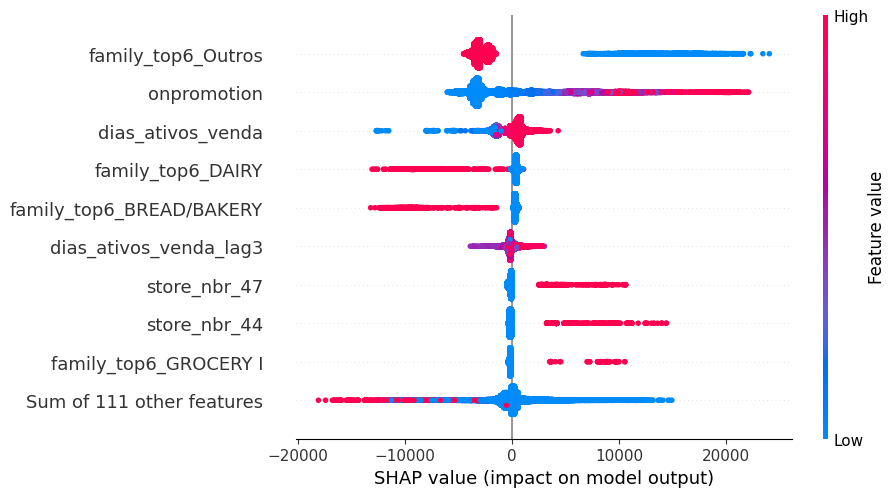

In [286]:
import shap

X_teste = X_teste.astype('float64')
# Criar o explicador
explainer = shap.Explainer(xgb_model, X_teste)

# Calcular os valores SHAP
shap_values = explainer(X_teste)

# Resumo gráfico geral
shap.plots.beeswarm(shap_values)